In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from feature_engine.creation import CyclicalFeatures
import tensorflow as tf

In [2]:
class LogisticRegression:
    
    def __init__(self, X, y, learningRate, maxIteration, tolerance, index=None, lrtest=False):
        self.train_X = X
        self.train_y = y
        self.learningRate = learningRate
        self.maxIteration = maxIteration
        self.tolerance = tolerance
        self.index = index
        self.lrtest = lrtest
   
    def addX0(self, X):
        np.column_stack([np.ones([X.shape[0], 1]), X])
        
    def sigmoid(self, z):
        sig = 1 / (1 + np.exp(-z))
        return sig
    
    def costFunction(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        loss = y * np.log(sig) + (1-y) * np.log(1 - sig)
        cost = - loss.sum()
        return cost
    
    def gradient(self, X, y):
        sig = self.sigmoid(X.dot(self.w))
        grad = (sig - y).dot(X)
        return grad
    
    def gradientDescent(self, X, y):
        losses = []
        prev_loss = float('inf')
        
        for i in tqdm(range(self.maxIteration), colour = 'red'):
            self.w = self.w - self.learningRate * self.gradient(X, y)
            current_loss = self.costFunction(X, y)
            diff_loss = np.abs(prev_loss - current_loss)
            losses.append(current_loss)
            
            if diff_loss < self.tolerance:
                print("The model stopped learning")
                break
                
            prev_loss = current_loss
            
        self.plot_cost(losses)
        
    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)
    
    def fit(self):
        self.w = np.ones(self.train_X.shape[1], dtype=np.float64)
        
        if self.index!=None:
            self.remove_index(self.index)
        
        print(self.train_X.shape)
        
        if self.lrtest == True:
            print("Finding the best Learning rate, solving using gradient descent")
            self.lr_test(self.train_X, self.train_y)
        
        else:
            print("Solving using gradient descent")
            self.gradientDescent(self.train_X, self.train_y)
            
            print("Evaluate the training results")
            y_hat_train = self.predict(self.train_X)
        
            recall, precision, f_score = self.evaluationFunction(self.train_y, y_hat_train)
            print("The recall of the model is {}".format(recall))
            print("The precision of the model is {}".format(precision))
            print("The F1 score of the model is {}".format(f_score))
        
            #self.plot()
            #self.scatterPlt()
            #self.plot3D()
        
    def lr_test(self, X, y):
        alphas = [0.1e-5, 0.5e-5, 0.1e-4, 0.5e-4, 0.1e-3, 0.5e-3, 0.1e-2, 0.01, 0.1]
        for lr in alphas:
            losses = []
            prev_loss = float('inf')
            for i in tqdm(range(self.maxIteration), colour = 'red'):
                self.w = self.w - lr * self.gradient(X, y)
                current_loss = self.costFunction(X, y)
                diff_loss = np.abs(prev_loss - current_loss)
                losses.append(current_loss)
            
                if diff_loss < self.tolerance:
                    print("The model stopped learning")
                    break
                
                prev_loss = current_loss
            
            self.plot_cost(losses)
            print("Evaluate the training results")
            y_hat_train = self.predict(self.train_X)
            print("Learning rate: ", lr)
            recall, precision, f_score = self.evaluationFunction(self.train_y, y_hat_train)
            print("The recall of the model is {}".format(recall))
            print("The precision of the model is {}".format(precision))
            print("The F1 score of the model is {}".format(f_score))
        
    def evaluationFunction(self, y, y_hat):
        
        y = (y==1)
        y_hat = (y_hat==1)
        
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        
        f_score = 2 * (precision * recall) / (precision + recall)
        
        return recall, precision, f_score
    
    def plot_cost(self, cost_sequence):
        #Data for plotting
        s = np.array(cost_sequence)
        t = np.arange(s.size)
        
        fig, ax = plt.subplots()
        ax.plot(t, s)
        
        ax.set(xlabel='iterations', ylabel='cost', title='cost trend')
        ax.grid()
        
        plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()
    
    '''
    def plot(self):
        plt.figure(figsize=(12, 8))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points
        ax.scatter3D(self.train_X[:, 0], self.train_X[:, 1], 
                     self.sigmoid(self.train_X.dot(self.w)), 
                     c = self.train_y[:], cmap='viridis', s=100);

        ax.set_xlim3d(55, 80)
        ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)
        
    def scatterPlt(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)


        ax.scatter(self.train_X[:, 0], self.train_X[:, 1], 
                   c=self.train_y[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')
        

    def plot3D(self):
        # evenly sampled points
        x_min, x_max = 55, 80
        y_min, y_max = 80, 240
        
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                             np.linspace(y_min, y_max, 250))
        
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = grid.dot(self.w).reshape(xx.shape)
        fig = plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter3D(self.train_X[:, 0], self.train_X[:, 1], 
                   c=self.train_y[:], s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()
    ''' 
        

"""
1 - Gradient Descent
2 - learningrate, maxIteration, tolerance, X, y
3 - add column 0
4 - normalize function
5 - sigmoid function
6 - cost function
7 - gradient
8 - predict function
9 - fit function
10 - evaluation function
"""

print(__doc__)

In [3]:
def preprocess_data(df):
    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    df['default'] = df['default'].map({'yes': 1, 'no': 0})
    
    df['job'] = df['job'].replace({'unknown': 'job-unknown'}, regex=True)
    one_hot_job = pd.get_dummies(df['job'])
    one_hot_marital = pd.get_dummies(df['marital'])
    df['education'] = df['education'].replace({'unknown': 'edu-unknown'}, regex=True)
    one_hot_education = pd.get_dummies(df['education'])
    df['contact'] = df['contact'].replace({'unknown': 'contact-unknown'}, regex=True)
    one_hot_contact = pd.get_dummies(df['contact'])
    df['poutcome'] = df['poutcome'].replace({'unknown': 'poutcome-unknown'}, regex=True)
    one_hot_poutcome = pd.get_dummies(df['poutcome'])
    
    df = df.drop(['job','marital','education','contact','poutcome'],axis = 1)
    
    df = df.join(one_hot_education)
    df = df.join(one_hot_job)
    df = df.join(one_hot_marital)
    df = df.join(one_hot_contact)
    df = df.join(one_hot_poutcome)
    
    vals_to_replace = {'jan': 1,'feb': 2,'mar': 3,'apr': 4,'may': 5,'jun': 6,'jul': 7,'aug': 8,'sep': 9, 'oct': 10,'nov': 11,'dec': 12}
    df['month'] = df['month'].map(vals_to_replace)
    cyclical = CyclicalFeatures(variables=['day', 'month'], drop_original=True)
    X = cyclical.fit_transform(df)

    y = df['y'].map({'yes': 1, 'no': 0})
    X = df.drop('y', axis = 1)
    
    X=(X-X.mean())/X.std()

    return X, y

In [4]:
df = pd.read_csv('bank/bank-full.csv', sep=";")
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [13]:
train_df, test_df = train_test_split(df, test_size=0.2)
print(train_df.shape, test_df.shape)
train_X, train_y = preprocess_data(train_df)
print(train_X.head())
print(train_y.head())

(36168, 17) (9043, 17)
            age   default   balance   housing      loan       day     month  \
39876 -0.277114 -0.134321  0.187732 -1.117372 -0.437288 -1.658044 -0.060471   
45182 -0.652681 -0.134321 -0.404231 -1.117372 -0.437288 -0.097496  2.022492   
10277 -0.934356 -0.134321 -0.087837  0.894932 -0.437288 -0.457622 -0.060471   
11578  0.661803 -0.134321  0.560095 -1.117372 -0.437288  0.382672 -0.060471   
3316   0.286236 -0.134321 -0.236980 -1.117372 -0.437288 -0.097496 -0.477064   

       duration  campaign     pdays  ...  divorced   married    single  \
39876 -0.351753 -0.572408  2.583099  ... -0.358298  0.812156 -0.629290   
45182  0.556150 -0.249295  1.471147  ... -0.358298  0.812156 -0.629290   
10277 -0.638868  1.689387 -0.412158  ... -0.358298 -1.231257  1.589049   
11578 -0.080158  0.720046 -0.412158  ... -0.358298  0.812156 -0.629290   
3316  -0.002559 -0.572408 -0.412158  ... -0.358298 -1.231257  1.589049   

       cellular  contact-unknown  telephone   failure    

(36168, 37)
Solving using gradient descent


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/vishalbns/miniforge3/envs/mldl/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-2-4b8078754ab7>:37: RuntimeWarning: invalid value encountered in scalar subtract
  diff_loss = np.abs(prev_loss - current_loss)
100%|██████████| 10000/10000 [00:33<00:00, 300.34it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


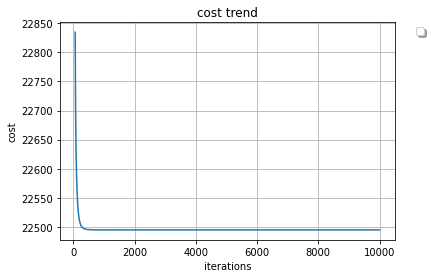

Evaluate the training results
The recall of the model is 0.8383049242424242
The precision of the model is 0.3389489805685843
The F1 score of the model is 0.482721014245791
age                 0.020677
default            -0.003552
balance             0.026693
housing            -0.127484
loan               -0.051291
day                -0.006697
month              -0.020664
duration            0.653536
campaign           -0.018084
pdays              -0.023107
previous            0.007028
edu-unknown         0.484120
primary             0.844578
secondary           1.194963
tertiary            1.135168
admin.              1.105021
blue-collar         1.393655
entrepreneur        0.595388
housemaid           0.553350
job-unknown         0.264821
management          1.391245
retired             0.805236
self-employed       0.610062
services            0.979168
student             0.553253
technician          1.276709
unemployed          0.574331
divorced            0.734143
married         

In [14]:
clf = LogisticRegression(train_X, train_y, learningRate=0.1e-4, maxIteration=10000, tolerance=0.00)
with tf.device('/device:GPU:0'):
    clf.fit()
print(clf.w)

In [15]:
test_X, test_y = preprocess_data(test_df)
test_y_hat = clf.predict(test_X)
clf.evaluationFunction(test_y, test_y_hat)

(0.8309859154929577, 0.337014470677837, 0.47954483879707394)

In [23]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(100), # add 100 dense neurons
    tf.keras.layers.Dense(10), # add another layer with 10 neurons
    tf.keras.layers.Dense(1)
])

In [33]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy', f1_m,precision_m, recall_m])

In [35]:
with tf.device('/device:GPU:0'):
    model.fit(train_X, train_y, epochs=10, verbose=0)

In [36]:
model.evaluate(test_X,test_y)

283/283 [==============================] - 2s 6ms/step - loss: 0.4580 - accuracy: 0.8461 - f1_m: 0.2963 - precision_m: 0.3286 - recall_m: 0.3155


[0.45803216099739075,
 0.8460687398910522,
 0.29634231328964233,
 0.3286036252975464,
 0.31552112102508545]